# Multiple particles falling in the F-layer

This notebook outlines how we can use our model of a single falling and growing iron particle 
to create a self consistent solution to propoerties of the F-layer and an estimate of the inner
core growth rate. We assume at the outset that we can track the growth and position of a single
falling iron particle with time. This is set up as a pair of coupled ODEs and solved as an IVP. 
This is implemented inside the `boundary_layer` model making use of the SciPy `integrate.solve_ivp`
interface to an explicit 5th order Runga-Kutta solver. We make extensive use of event tracking and
interpolated solutions given by this implementation.

The aim is to (1) look at how the results of our method varies with input parameters and (2)
compare our non-equilibrium approach to a simple equilibrium model. The results generated are
summarised in Figure **XX**, which this notebook generates.

The bulk of the code for this notebook lives in the `flayer` module (see `flayer.py`). This
module makes use of almost all of our other modules either directly or indirectly. 


In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import scipy.optimize as spo
import scipy.interpolate as spi
import particle_evolution
import feo_thermodynamics as feot
import earth_model
import flayer

## F-layer setup

We need a reasonable description of the F-layer. We do this by defining a radius for the ICB 
and a radius for the top of the F-layer, assume that pressure (and gravity) are given by PREM,
and define functions for temperature and composition. (The following function generates the functions
we'll need). 

The (total) composition is assumed to be constant in the core above the F-layer, and may vary as a linear 
function of radius within the F-layer. This is set up by providing two compositions, one
at the top and one at the bottom of the F-layer. These are provided as mole fraction Fe
and are needed to set up the temperature.

For temperature we extrapolate down an adiabat until we reach the top of the F-layer and then
assume a linear variation in temperature with radius. The adiabatic temperature is given by:

$$ T_a(r) = T_{CMB} \left(\frac{\rho(r)}{\rho_{CMB}}\right)^{\gamma} $$

where $\gamma$ is the Grunissen parameter for the core (e.g. 1.5) and $T_{CMB}$ is the 
temperature at the CMB. We $\gamma$, assume PREM for the density, and find $T_{CMB}$ such
that $T_a(r)$ is equal to the liquidus (at our chosen composition) at the top of the F-layer.
This is done by root finding. 
We choose the temperature at the ICB by further extrapolating down the adiabat and applying 
a small change (or order 10 K) such that the F-layer can be sub- (or super-) adiabatic.

Note that allowing the temperature and composition to vary with radius could allow the
F-layer to depart from the two phase region (either by dipping below the solidus/eutectic
temperature or by exceeding the pressure-dependent liquidus). Do check.

Pressure at ICB: 329.1010089948369 GPa
Pressure at top of F-layer 317.7026904318656 GPa
g at ICB: 4.403124222842614 m/s**2
g at top of F-layer 5.010242771751181 m/s**2


/Users/andrewwalker/miniforge3/envs/py39/lib/python3.9/site-packages/numpy/lib/function_base.py:2197: RuntimeWarning: invalid value encountered in find_liquidus (vectorized)
  outputs = ufunc(*inputs)


Temperature at CMB is 4091.0000127665962 K
Temberature at top of F-layer is 5495.375594101565 K
Temberature at ICB is 5560.445773134292 K


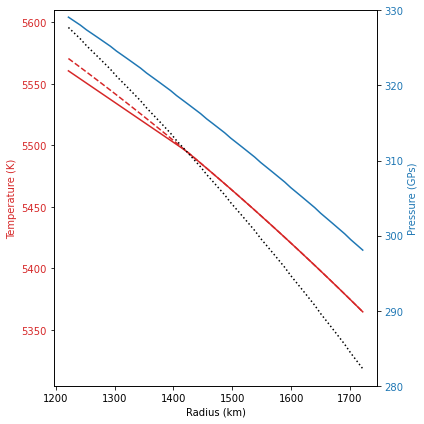

In [2]:
# This is where we set all the F-layer parameters. Quite slow (due to liquidus calc I think)

# F-layer setup
radius_inner_core = 1221.5e3
radius_top_flayer = radius_inner_core + 200.0e3 # 200 km thick.
radius_cmb = 3480.0e3 # We only need this for setup.
gamma = 1.5

# Check PREM works ... and print some interesting values
prem = earth_model.Prem()
print("Pressure at ICB:", prem.pressure(radius_inner_core/1000.0), "GPa")
print("Pressure at top of F-layer", prem.pressure(radius_top_flayer/1000.0), "GPa")
print("g at ICB:", prem.gravity(radius_inner_core/1000.0), "m/s**2")
print("g at top of F-layer", prem.gravity(radius_top_flayer/1000.0), "m/s**2")

# Generate the functions for temperautre,
# composition, pressure and gravity
tfunc, atfunc, xfunc, pfunc, \
    gfunc = flayer.setup_flayer_functions(radius_inner_core, radius_cmb, radius_top_flayer, 
                                                    gamma, 10.0, 0.92, 0.92)

print("Temperature at CMB is", tfunc(radius_cmb), "K")
print("Temberature at top of F-layer is", tfunc(radius_top_flayer), "K")
print("Temberature at ICB is", tfunc(radius_inner_core), "K")

# Interpolate onto radius for plotting
rs = np.linspace(radius_inner_core, radius_inner_core+500.0E3)
ts = tfunc(rs)
ats = atfunc(rs)
ps = pfunc(rs)
xs = xfunc(rs)
# Find the P-X dependent liquidus (storing the temperature at each point)
tl = feot.find_liquidus(xs, ps)


# Plot the F-layer setup alongside the liquidus
fig, ax1 = plt.subplots(figsize=(6,6), tight_layout=True)

color = 'tab:red'
ax1.set_xlabel('Radius (km)')
ax1.set_ylabel('Temperature (K)', color=color)
ax1.plot(rs/1000.0, ts, color=color)
ax1.plot(rs/1000.0, ats, color=color, ls='--')
ax1.plot(rs/1000.0, tl, color='k', ls=':')

ax1.tick_params(axis='y', labelcolor=color)
#ax1.set_ylim([5900, 6200])

ax2 = ax1.twinx()  

color = 'tab:blue'
ax2.set_ylabel('Pressure (GPs)', color=color)  
ax2.plot(rs/1000.0, ps, color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim([280, 330])

fig.tight_layout()  
plt.show()

## Equilibrium calculation

We've covered all of this before elsewhere. The only innovation is to 
allow pressure and composition to vary with temperature.

/Users/andrewwalker/miniforge3/envs/py39/lib/python3.9/site-packages/numpy/lib/function_base.py:2197: RuntimeWarning: invalid value encountered in phase_relations_molar (vectorized)
  outputs = ufunc(*inputs)
/Users/andrewwalker/miniforge3/envs/py39/lib/python3.9/site-packages/numpy/lib/function_base.py:2197: RuntimeWarning: invalid value encountered in phase_relations_molar (vectorized)
  outputs = ufunc(*inputs)


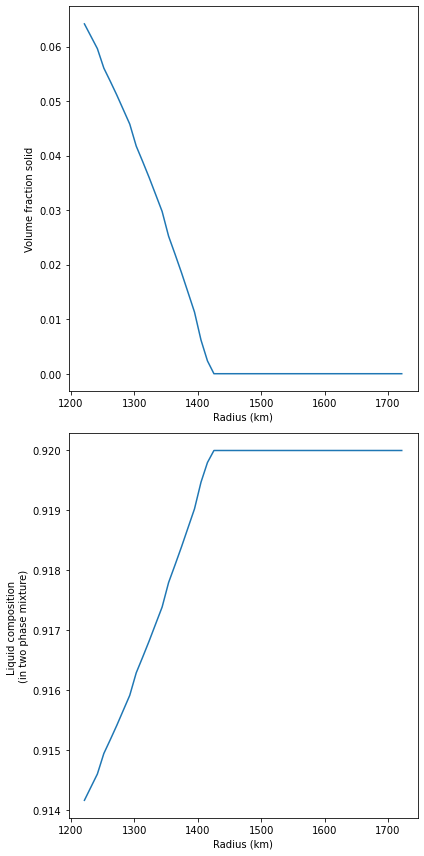

In [3]:
equilib_vol_frac = feot.volume_fraction_solid(xs, ps, ts) # Why do these give steppy answers?
x_lq, phi_fe, phi_lq, phi_feo, phi_solid = feot.phase_relations_molar(xs, ps, ts)

fig, ax = plt.subplots(nrows=2, figsize=(6,12), tight_layout=True)
ax[0].plot(rs/1000.0, equilib_vol_frac)
ax[0].set_ylabel('Volume fraction solid')
ax[0].set_xlabel('Radius (km)')
ax[1].plot(rs/1000.0, x_lq)
ax[1].set_ylabel('Liquid composition \n(in two phase mixture)')
ax[1].set_xlabel('Radius (km)')
plt.show()

**To Do:** 
1. work out why we have the steps in the melting curve and the phase relations output. Looks like
some numerical convergence thing but I would expect that to be more random.
2. Think about falling time and crstal size in the equilibrium case. 
3. Think about physical propertiese (layer density structure, bulk modulii, P-wave velocity

**TODO: check and integrate Chris comments. Do we care about the spacing any more?

## Non-equilibrium calculation

For the overall non-equilibrium calculation we make use of the previously implemented
code to track the growth and falling velocity of an isolated crystal. The new step
is to bring these together into a model of the F-layer. Setup of the F-layer is
described above.

### The particle density and optimisation of theliquid composition

Thus far we have treated the liquid composition around the falling particles as an
externally imposed parameter. However, we would like the composition (in terms of 
total oxygen content) of the F-layer to be conserved. As crystals grow oxygen
is enriched in the residual liquid (because it is excluded from the solid). What
we do is run a set of calculations with the liquid oxygen content set equal to the
imposed total oxygen content. Calculate the volume of solid in the F-layer from this
calculation and use this to recalculate the liquid composition (assuming that the
boundary layers play an insignificant role in the overall composition, and that the
total oxygen in the F-layer is conserved). This gives a new total oxygen content in
the layer. We then use this as the imposed oxygen content for the particle evolution
equation and iterate. We hope this converges (**question: can we argue that it must on
the basis of the growth rate being related to the oxygen content of the liquid?**)

In fact, we want the F-layer to be able to generate a gradient in oxygen content
and solid volume fraction. We'll thus set up a serise of layers and conserve
oxygen content in eacg layer. **Question: what sort of non-equilibroum will this
permit? The bulk liquid composition will not be the composition that is in
equilibrioum with the solid due to the boundary layer. This means that (once convereged)
we will not be in phase equilibrium either. However, we will conserve mass. 
I think this measn we say something like "we allow departures from phase equilibrium
and only impose chemical equilibrium in a limited way (no gradients in bulk solid or
bulk liquid).** 

In order to set this up we need to self consistently
solve the falling particles ODEs using the following algorithem:

1. Set an initial guess for the liquid composition (equal to the total composition)
2. Solve ODEs 
3. Calculate liquid composition in each layer such that the total coposition is conserved
4. If these do no match repeate from 2 otherwise
5. Evaluate crystal size distribution and inner core growth rate.

Note that for many falling particles nucleating throughout the liquid composition will
need to change through the layer (we may expect it will be more oxygen rich downwards as the 
number density of particles and their sizes increases downwards). 

Given the above, we need a way to evaluate the number density and total volume of particles at any
depth in the F-layer. The information we have is the nuclation rate, $\mathscr{N}(r_n)$, 
and relationship between the particle position $r_p(r_n, t)$ with time, $t$. Both are functions
of the nuclation position $r_n$. We also have access to the particle radius, $R(r_n, t)$. 

We start by calculating the 'partial number density', number of particles per cubic meter that
at position $r$ that nucleated at $r_n$. For this we need the spacing between particles nuclating
in a given volume around $r_n$, which we call $V_n$. From the definition of $\mathscr{N}$ we
know that the mean waiting time between nucleation events is:

$$\tau = \frac{1}{2 \mathscr{N}(r_n) V_n}$$

and the mean position of nucleation will be at the center of the volume represented by $V_n$.
The factor of a $\frac{1}{2}$ arised because half of the nuclii that reach the critical radius
then dissolve (some definitions of $\mathscr{N}$ will not include this). $\tau$ should be in
units of time.

Particles falling from any given location will follow identicle trajectories whatever time they
start (because we are assuming the F-layer is in steady state). That is, if $r_p(r_n, t)$ and
$R(r_n, t)$ are solutions to the IVP for a particle nucleating at $t_0$, solutions for an IVP
where the particle nucleated at $t_0 + \tau$ will be $r_p(r_n, t + \tau)$ and $R(r_n, t + \tau)$
and we have solutions available whatever the nucleation time. At some $r$ we can thus calculate
the vertical distance, $s_z$ between particles by taking the difference in $r_p$ for particles
nucleating $\tau$ before and after $t_0$:

$$s_z = \frac{\left(r_p(r_n, t) - r_p(r_n, t + \tau)\right) + \left(r_p(r_n, t - \tau) + r_p(r_n, t)\right)}{2}$$

And the vertical partial particle density is $\rho_p(r_n) = \frac{1}{s_z}$. The seperation between paticles in
the horizontal direction is determined by the cross sectional area of the nucleation volume 
(the particles just sink downwards). On average this will be the distance between the centers of
the nucleation volumes. If we arrange for the cross-sectional area to be 1 m$^2$ the vertical 
parital particle density will be the partial particle density (in particles per m$^3$). We can
either envisage these particles to nucleate and fall in 'sheets' or imagine a stocastic process
(in which case the positions are the mean positions and the density is a mean density. This
analysis ignores the change in shell area with radius. **Note: do we need to account for change in
cross sectional area with r in spherical geometry?**



We now need to consider the paricles that nucleate at other depths. These will have different solutions
to the IVP, and thus different seperations and densities. The total (number) density of particles
at some depth $\rho(r)$, is just the sum of the partial densities from all nucleation depths above the height of
interest. We can evaluate this as an integral over nucleation depths:

$$\rho(r) = \int_{r}^{r_{top}} \rho_p(r_n) \mathrm{d}r_n $$

where $r_{top}$ is the top of the F-layer.

So we need to calculate $\rho(r)$ at some set of radii, convert this into a particle seperation, express the 
seperation as a contiuous function, and feed this back in as the radius of the interaction volume in the IVPs.
The iteraction radius (particle seperation) is given by the Wigner–Seitz radius:

$$r_{sep}(r) = \left(\frac{3}{4\pi\rho(r)}\right)^{\frac{1}{3}} $$

### Inner core growth

Once we have a self-consistent solution, it is quite easy to evaluate the solid
volume fraction at any radius, and the inner core growth rate. 

The inner core growth rate (by sedimentation), $G_{ic}$, is given by the volume of solid reaching the
ICB per unit time. This is found by integrating the volume of particles that formed everywhere in the 
F-layer according to their nuclation radius and deviding by the area of the ICB:

$$G_{ic} = \frac{1}{ 4 \pi r_{icb}^2}\int_{r_{icb}}^{r_{top}} 4 \pi r_n^2 . \frac{4}{3}\pi R(r_n, t_{icb})^3 . \frac{ \mathscr{N}(r_n)}{2} \mathrm{d}r_n$$

The term outside the integral is the area of the ICB. The first term inside the intergral accounts for the 
spherical shell geometry, the second is the volume of the particles as they reach the ICB having nucleated
at $r_n$, and the third term gives the number of these particles. The integral is over nucleation position.

**To do:** do we actually implement the factor of a half in the nucleation rate?


### Solid volume fraction

The volume fraction solid, $V_f(r)$ at any radius can be evaluated in a similar way as the total volume of solid
(per unit volume) is the product of the particle number density and the radii:

$$V_f(r) = \int_{r}^{r_{top}} \rho_p(r_n) \frac{4}{3}\pi R(r_n, t_r)^3 \mathrm{d}r_n $$

**To do:** do we need a geometrical term?

Once we know $V_f(r)$ we can evaluate the liquid composition (and thus density) by conservation of oxygen 
(all the oxygen is in the liquid).

### Implementation

We choose a set of integration depths / nucleation depths ($r_n$) above and use each one as the starting
depth for the IVP solver and for the descrete depths for numerical integration of the integrals above. 
Some brief testing seems to show that O(10) is more than enough points for the case I looked at (but careful
checking may be useful). We also choose a set of radii (just $r$ above) where we want to evaluate $\rho_p$ and 
$V_f$. We provide these to the IVP solver as non terminal 'events' and also check for dissolution of the particle
and for the particle hitting the ICB (these are 'terminal events'). What this means is that we can easily get hold
of the time and particle radius when the solution hit these depths from the IVP solution objects. We run each IVP
and store the solution objects in a list. We also need to apply small changes to the time to work out the 
seperation between particles. We do this by asking the IVP solver to fit an interpolation function to the solution.
We can then use the time (from the event) and apply an offset to find the position the particle was at a short time
before or after the event was triggered. We can use the termination event to find the ICB growth rate. To make this
all work we need to know when event corresponds to which depth. Events are stored (in the IVP solution) in a list.
Event 0 is 'hit the ICB', event 1 is 'dissolved' and subsiquent events correspond to our analysis radii in order.
Note that accessing these events needs us to check that the particle has not dissovled (or never reached) the analysis
radius of interest. Super. Glad that makes sense. It is also useful to know that the events information is stored in
`t_events` (for times) and `y_events` (for radius, in element 0, and position, in element 1). 

This may all make a bit more sense in terms of code. The function in the next cell just dumps out everything we 
know about the events found in a single IVP solution. Last thing to watch - events can (in principle) be triggered
multiple times, so we have to watch for this!

### The actual integration

The next couple of cells shows how this can be used and illustrate one solution. 

Note that as well as F-layer setup (above) we have other parameters to set here.

In [4]:
# IVP defaults
start_time = 0 # s
max_time = 1.0E20 # s

# Physical properties
initial_particle_size = 1.0E-9 # initial radius, m - should be critical radius for nucleation
k0 = 150.0 # growth rate prefactor, m/s
dl = 1.0E-9 # diffusion
mu = 1.0e-6 # kinematic viscosity

nucleation_radii = np.linspace(radius_inner_core, radius_top_flayer, 20)
analysis_radii = np.linspace(radius_inner_core, radius_top_flayer, 20)

nucleation_rates = np.ones_like(nucleation_radii)*1.0E-14 # Same everywhere

solutions, particle_densities, growth_rate, solid_vf, \
    particle_radius_unnormalised, particle_radius_histogram, opt_xlfunc = flayer.evaluate_flayer(
    tfunc, xfunc, pfunc, gfunc, start_time, max_time, initial_particle_size, k0, dl, mu,
    nucleation_radii, nucleation_rates, analysis_radii, radius_inner_core, radius_top_flayer)

Starting ODE IVP solver for nuclation at 1221500.001
icb at t =  80.89169597496598 s, with particle radius =  2.4005632521640487e-05
did not dissolve
did not reach r =  1221500.0 m
did not reach r =  1232026.3157894737 m
did not reach r =  1242552.6315789474 m
did not reach r =  1253078.9473684211 m
did not reach r =  1263605.2631578948 m
did not reach r =  1274131.5789473685 m
did not reach r =  1284657.894736842 m
did not reach r =  1295184.2105263157 m
did not reach r =  1305710.5263157894 m
did not reach r =  1316236.8421052631 m
did not reach r =  1326763.1578947369 m
did not reach r =  1337289.4736842106 m
did not reach r =  1347815.7894736843 m
did not reach r =  1358342.105263158 m
did not reach r =  1368868.4210526317 m
did not reach r =  1379394.7368421052 m
did not reach r =  1389921.0526315789 m
did not reach r =  1400447.3684210526 m
did not reach r =  1410973.6842105263 m
did not reach r =  1421500.0 m

Starting ODE IVP solver for nuclation at 1232026.3167894736
icb at t 

icb at t =  807337.4714247352 s, with particle radius =  0.021040690593982603
did not dissolve
did not reach r =  1221500.0 m
reached r =  1232026.3157894737 m at t =  739549.217019535 s, with particle radius =  0.01920662014612422
reached r =  1242552.6315789474 m at t =  669075.073169203 s, with particle radius =  0.01733368919143011
reached r =  1253078.9473684211 m at t =  595221.7125525342 s, with particle radius =  0.01539904208610994
reached r =  1263605.2631578948 m at t =  516935.28469878784 s, with particle radius =  0.013380930513378126
reached r =  1274131.5789473685 m at t =  432408.33604378597 s, with particle radius =  0.011253971881772563
reached r =  1284657.894736842 m at t =  338045.4400014211 s, with particle radius =  0.008910233896301075
reached r =  1295184.2105263157 m at t =  224399.86973687878 s, with particle radius =  0.006099168237107918
reached r =  1305710.5263157894 m at t =  102.16369189329956 s, with particle radius =  2.1085599866141713e-05
did not re

icb at t =  1377474.056834117 s, with particle radius =  0.02577180753601386
did not dissolve
did not reach r =  1221500.0 m
reached r =  1232026.3157894737 m at t =  1315585.0689814594 s, with particle radius =  0.024204927570660992
reached r =  1242552.6315789474 m at t =  1252257.8982240784 s, with particle radius =  0.022639599639823486
reached r =  1253078.9473684211 m at t =  1187299.9923265793 s, with particle radius =  0.02106733675547566
reached r =  1263605.2631578948 m at t =  1120474.1721305691 s, with particle radius =  0.019484738261642133
reached r =  1274131.5789473685 m at t =  1051483.4684394035 s, with particle radius =  0.017895059402771717
reached r =  1284657.894736842 m at t =  979948.5645127619 s, with particle radius =  0.016310548343398453
reached r =  1295184.2105263157 m at t =  905366.0181306413 s, with particle radius =  0.01471749197220494
reached r =  1305710.5263157894 m at t =  826972.3015503243 s, with particle radius =  0.013103399864846274
reached r

did not reach icb
particle dissolved at t =  1326230.502760222 s
did not reach r =  1221500.0 m
did not reach r =  1232026.3157894737 m
did not reach r =  1242552.6315789474 m
did not reach r =  1253078.9473684211 m
did not reach r =  1263605.2631578948 m
did not reach r =  1274131.5789473685 m
did not reach r =  1284657.894736842 m
did not reach r =  1295184.2105263157 m
did not reach r =  1305710.5263157894 m
did not reach r =  1316236.8421052631 m
did not reach r =  1326763.1578947369 m
did not reach r =  1337289.4736842106 m
did not reach r =  1347815.7894736843 m
did not reach r =  1358342.105263158 m
did not reach r =  1368868.4210526317 m
did not reach r =  1379394.7368421052 m
did not reach r =  1389921.0526315789 m
did not reach r =  1400447.3684210526 m
did not reach r =  1410973.6842105263 m
reached r =  1421500.0 m at t =  755134.4262241933 s, with particle radius =  2.2191181339599525e-07

ODE solved for all nuclation depths... calculating integrals over nuclation depth fo


Partial density calc for r = 1410973.6842105263 with nuc at r = 1232026.3157894737 nuc_rate =  1e-14 nuc_vol =  10526315789.47371

Partial density calc for r = 1410973.6842105263 with nuc at r = 1242552.6315789474 nuc_rate =  1e-14 nuc_vol =  10526315789.47371

Partial density calc for r = 1410973.6842105263 with nuc at r = 1253078.9473684211 nuc_rate =  1e-14 nuc_vol =  10526315789.47371

Partial density calc for r = 1410973.6842105263 with nuc at r = 1263605.2631578948 nuc_rate =  1e-14 nuc_vol =  10526315789.47371

Partial density calc for r = 1410973.6842105263 with nuc at r = 1274131.5789473685 nuc_rate =  1e-14 nuc_vol =  10526315789.473476

Partial density calc for r = 1410973.6842105263 with nuc at r = 1284657.894736842 nuc_rate =  1e-14 nuc_vol =  10526315789.47371

Partial density calc for r = 1410973.6842105263 with nuc at r = 1295184.2105263157 nuc_rate =  1e-14 nuc_vol =  10526315789.47371

Partial density calc for r = 1410973.6842105263 with nuc at r = 1305710.5263157894

icb at t =  393045.4241546459 s, with particle radius =  0.013232210068756438
did not dissolve
did not reach r =  1221500.0 m
reached r =  1232026.3157894737 m at t =  305365.53593914944 s, with particle radius =  0.010501654570093623
reached r =  1242552.6315789474 m at t =  201215.5135929588 s, with particle radius =  0.007190767137676307
reached r =  1253078.9473684211 m at t =  87.24088412410649 s, with particle radius =  2.2982702477311965e-05
did not reach r =  1263605.2631578948 m
did not reach r =  1274131.5789473685 m
did not reach r =  1284657.894736842 m
did not reach r =  1295184.2105263157 m
did not reach r =  1305710.5263157894 m
did not reach r =  1316236.8421052631 m
did not reach r =  1326763.1578947369 m
did not reach r =  1337289.4736842106 m
did not reach r =  1347815.7894736843 m
did not reach r =  1358342.105263158 m
did not reach r =  1368868.4210526317 m
did not reach r =  1379394.7368421052 m
did not reach r =  1389921.0526315789 m
did not reach r =  1400447.36

icb at t =  977462.1650256376 s, with particle radius =  0.0231289469650722
did not dissolve
did not reach r =  1221500.0 m
reached r =  1232026.3157894737 m at t =  912492.7249156713 s, with particle radius =  0.021409107873072823
reached r =  1242552.6315789474 m at t =  845561.306350465 s, with particle radius =  0.019675496237674915
reached r =  1253078.9473684211 m at t =  776240.1235612438 s, with particle radius =  0.01790448592596572
reached r =  1263605.2631578948 m at t =  703962.7058105136 s, with particle radius =  0.016090783081201654
reached r =  1274131.5789473685 m at t =  627951.9970941675 s, with particle radius =  0.014236694087054037
reached r =  1284657.894736842 m at t =  547107.8732265086 s, with particle radius =  0.012355570383667212
reached r =  1295184.2105263157 m at t =  459432.64961608767 s, with particle radius =  0.010359048130952578
reached r =  1305710.5263157894 m at t =  360760.6822901266 s, with particle radius =  0.008148161108442267
reached r =  1

icb at t =  1503494.2623440714 s, with particle radius =  0.026197312877349017
did not dissolve
did not reach r =  1221500.0 m
reached r =  1232026.3157894737 m at t =  1442012.3830668852 s, with particle radius =  0.024634868847451925
reached r =  1242552.6315789474 m at t =  1379148.1482453858 s, with particle radius =  0.02307331836963727
reached r =  1253078.9473684211 m at t =  1314731.0637079165 s, with particle radius =  0.021513668683916565
reached r =  1263605.2631578948 m at t =  1248552.605125247 s, with particle radius =  0.019959452751665628
reached r =  1274131.5789473685 m at t =  1180396.4327103542 s, with particle radius =  0.01841367106212935
reached r =  1284657.894736842 m at t =  1109924.6837707553 s, with particle radius =  0.016871461831300096
reached r =  1295184.2105263157 m at t =  1036662.2086735227 s, with particle radius =  0.015327456899078211
reached r =  1305710.5263157894 m at t =  959996.7564969199 s, with particle radius =  0.01377786466960296
reached

did not reach icb
particle dissolved at t =  1326230.502760222 s
did not reach r =  1221500.0 m
did not reach r =  1232026.3157894737 m
did not reach r =  1242552.6315789474 m
did not reach r =  1253078.9473684211 m
did not reach r =  1263605.2631578948 m
did not reach r =  1274131.5789473685 m
did not reach r =  1284657.894736842 m
did not reach r =  1295184.2105263157 m
did not reach r =  1305710.5263157894 m
did not reach r =  1316236.8421052631 m
did not reach r =  1326763.1578947369 m
did not reach r =  1337289.4736842106 m
did not reach r =  1347815.7894736843 m
did not reach r =  1358342.105263158 m
did not reach r =  1368868.4210526317 m
did not reach r =  1379394.7368421052 m
did not reach r =  1389921.0526315789 m
did not reach r =  1400447.3684210526 m
did not reach r =  1410973.6842105263 m
reached r =  1421500.0 m at t =  755134.4262241933 s, with particle radius =  2.2191181339599525e-07

ODE solved for all nuclation depths... calculating integrals over nuclation depth fo

Partial density calc for r = 1389921.0526315789 with nuc at r = 1316236.8421052631 nuc_rate =  1e-14 nuc_vol =  10526315789.47371

Partial density calc for r = 1389921.0526315789 with nuc at r = 1326763.1578947369 nuc_rate =  1e-14 nuc_vol =  10526315789.47371

Partial density calc for r = 1389921.0526315789 with nuc at r = 1337289.4736842106 nuc_rate =  1e-14 nuc_vol =  10526315789.47371

Partial density calc for r = 1389921.0526315789 with nuc at r = 1347815.7894736843 nuc_rate =  1e-14 nuc_vol =  10526315789.47371

Partial density calc for r = 1389921.0526315789 with nuc at r = 1358342.105263158 nuc_rate =  1e-14 nuc_vol =  10526315789.47371

Partial density calc for r = 1389921.0526315789 with nuc at r = 1368868.4210526317 nuc_rate =  1e-14 nuc_vol =  10526315789.47371

Partial density calc for r = 1389921.0526315789 with nuc at r = 1379394.7368421052 nuc_rate =  1e-14 nuc_vol =  10526315789.473476

Partial density calc for r = 1389921.0526315789 with nuc at r = 1389921.0526315789 

In [5]:
calculated_seperation, growth_rate = flayer.analyse_flayer(solutions, nucleation_radii, analysis_radii, nucleation_rates, radius_inner_core,
                   particle_densities, growth_rate, solid_vf, 
                   particle_radius_unnormalised, particle_radius_histogram)

Ar r = 1221500.0 m, particle density =  0.0 per m^3, calculated seperation radius =  inf m
Ar r = 1232026.3157894737 m, particle density =  0.0002570208144626634 per m^3, calculated seperation radius =  9.756956417343908 m
Ar r = 1242552.6315789474 m, particle density =  0.00024742066619603506 per m^3, calculated seperation radius =  9.881551526773066 m
Ar r = 1253078.9473684211 m, particle density =  0.0002378893047514732 per m^3, calculated seperation radius =  10.011799827294896 m
Ar r = 1263605.2631578948 m, particle density =  0.0002282172974520341 per m^3, calculated seperation radius =  10.151283207288328 m
Ar r = 1274131.5789473685 m, particle density =  0.0002183992267695716 per m^3, calculated seperation radius =  10.30117498981414 m
Ar r = 1284657.894736842 m, particle density =  0.00020845477986935774 per m^3, calculated seperation radius =  10.462444749847679 m
Ar r = 1295184.2105263157 m, particle density =  0.00019858280761695025 per m^3, calculated seperation radius =  

/Users/andrewwalker/miniforge3/envs/py39/lib/python3.9/site-packages/numpy/lib/function_base.py:2197: RuntimeWarning: invalid value encountered in phase_relations_molar (vectorized)
  outputs = ufunc(*inputs)
/Users/andrewwalker/miniforge3/envs/py39/lib/python3.9/site-packages/numpy/lib/function_base.py:2197: RuntimeWarning: invalid value encountered in phase_relations_molar (vectorized)
  outputs = ufunc(*inputs)


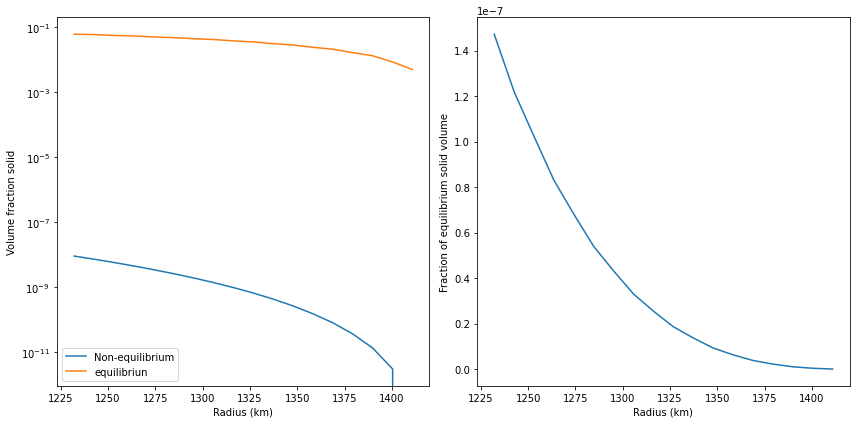

In [6]:
fig, axs = plt.subplots(ncols=2, figsize=(12,6), tight_layout=True)
ax = axs[0]
ax.plot(analysis_radii[1:-1]/1000.0, solid_vf[1:-1], label='Non-equilibrium')

ax.plot(analysis_radii[1:-1]/1000.0, feot.volume_fraction_solid(xfunc(analysis_radii[1:-1]), 
                                                                pfunc(analysis_radii[1:-1]), 
                                                                tfunc(analysis_radii[1:-1])), label='equilibriun')
ax.set_yscale("log", nonpositive='clip')
ax.set_ylabel('Volume fraction solid')
ax.set_xlabel('Radius (km)')
ax.legend()

ax = axs[1]
ax.plot(analysis_radii[1:-1]/1000.0, 
        solid_vf[1:-1] / feot.volume_fraction_solid(xfunc(analysis_radii[1:-1]), 
                                                                pfunc(analysis_radii[1:-1]), 
                                                                tfunc(analysis_radii[1:-1])))
ax.set_ylabel('Fraction of equilibrium solid volume')
ax.set_xlabel('Radius (km)')

plt.show()

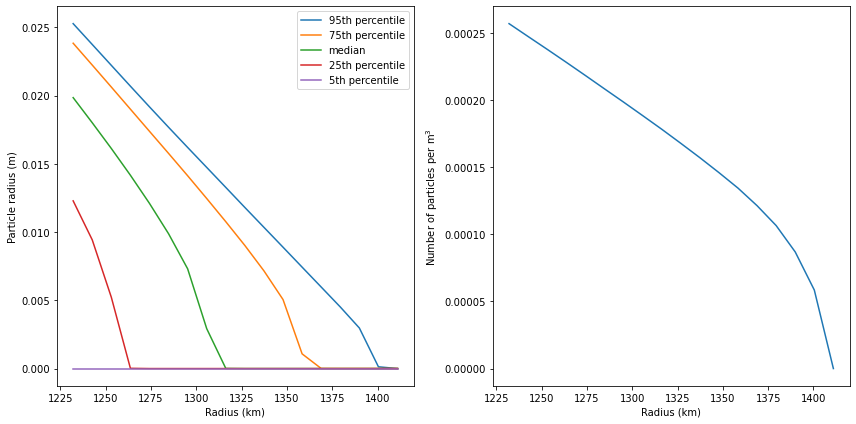

In [7]:
fig, axs = plt.subplots(ncols=2, figsize=(12,6), tight_layout=True)

ax = axs[0]
#ax.plot(analysis_radii[1:-1]/1000.0, np.max(particle_radius_unnormalised[1:-1], axis=1), label='max')
#ax.plot(analysis_radii[1:-1]/1000.0, np.mean(particle_radius_unnormalised[1:-1], axis=1), label='mean')
ax.plot(analysis_radii[1:-1]/1000.0, np.percentile(particle_radius_unnormalised[1:-1], 95, axis=1),
        label='95th percentile')
ax.plot(analysis_radii[1:-1]/1000.0, np.percentile(particle_radius_unnormalised[1:-1], 75, axis=1),
        label='75th percentile')
ax.plot(analysis_radii[1:-1]/1000.0, np.percentile(particle_radius_unnormalised[1:-1], 50, axis=1),
        label='median')
ax.plot(analysis_radii[1:-1]/1000.0, np.percentile(particle_radius_unnormalised[1:-1], 25, axis=1),
        label='25th percentile')
ax.plot(analysis_radii[1:-1]/1000.0, np.percentile(particle_radius_unnormalised[1:-1], 5, axis=1),
        label='5th percentile')
ax.set_xlabel('Radius (km)')
ax.set_ylabel('Particle radius (m)')
ax.legend()

ax = axs[1]
ax.plot(analysis_radii[1:-1]/1000.0, particle_densities[1:-1])
ax.set_xlabel('Radius (km)')
ax.set_ylabel('Number of particles per m$^3$')
#ax.legend()

plt.show()

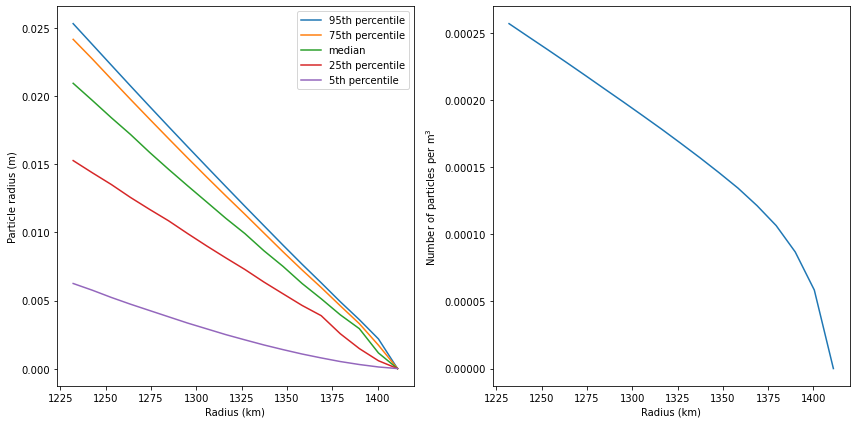

In [8]:
import numpy.ma as ma
masked_particle_radius_unnormalised = ma.masked_less(particle_radius_unnormalised, 1.0E-9)
masked_particle_radius_unnormalised = np.ma.filled(masked_particle_radius_unnormalised, np.nan)

fig, axs = plt.subplots(ncols=2, figsize=(12,6), tight_layout=True)

ax = axs[0]
#ax.plot(analysis_radii[1:-1]/1000.0, np.max(particle_radius_unnormalised[1:-1], axis=1), label='max')
#ax.plot(analysis_radii[1:-1]/1000.0, np.mean(particle_radius_unnormalised[1:-1], axis=1), label='mean')
ax.plot(analysis_radii[1:-1]/1000.0, np.nanpercentile(masked_particle_radius_unnormalised[1:-1], 95, axis=1),
        label='95th percentile')
ax.plot(analysis_radii[1:-1]/1000.0, np.nanpercentile(masked_particle_radius_unnormalised[1:-1], 75, axis=1),
        label='75th percentile')
ax.plot(analysis_radii[1:-1]/1000.0, np.nanpercentile(masked_particle_radius_unnormalised[1:-1], 50, axis=1),
        label='median')
ax.plot(analysis_radii[1:-1]/1000.0, np.nanpercentile(masked_particle_radius_unnormalised[1:-1], 25, axis=1),
        label='25th percentile')
ax.plot(analysis_radii[1:-1]/1000.0, np.nanpercentile(masked_particle_radius_unnormalised[1:-1], 5, axis=1),
        label='5th percentile')
ax.set_xlabel('Radius (km)')
ax.set_ylabel('Particle radius (m)')
ax.legend()

ax = axs[1]
ax.plot(analysis_radii[1:-1]/1000.0, particle_densities[1:-1])
ax.set_xlabel('Radius (km)')
ax.set_ylabel('Number of particles per m$^3$')
#ax.legend()

plt.show()

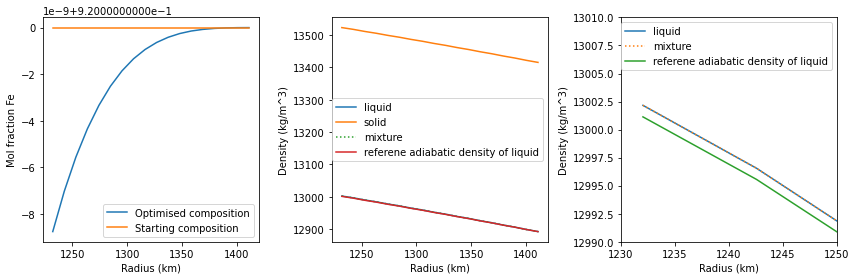

In [9]:
liquid_density, solid_mixture_density, fe_liquid_density, fe_hpc_density, \
           feo_liquid_density, feo_solid_density = feot.densities(opt_xlfunc(analysis_radii[1:-1]),
                                                                             pfunc(analysis_radii[1:-1]), 
                                                                             tfunc(analysis_radii[1:-1]))

ad_liquid_density, _, _, _, _, _ = feot.densities(xfunc(analysis_radii[1:-1]),
                                                                             pfunc(analysis_radii[1:-1]), 
                                                                             atfunc(analysis_radii[1:-1]))

fig, axs = plt.subplots(ncols=3, figsize=(12,4), tight_layout=True)

ax = axs[0]
ax.plot(analysis_radii[1:-1]/1000.0, opt_xlfunc(analysis_radii[1:-1]), label='Optimised composition')
ax.plot(analysis_radii[1:-1]/1000.0, xfunc(analysis_radii[1:-1]), label='Starting composition')
ax.set_xlabel('Radius (km)')
ax.set_ylabel('Mol fraction Fe')
ax.legend()

ax = axs[1]
ax.plot(analysis_radii[1:-1]/1000.0, liquid_density, label='liquid')
ax.plot(analysis_radii[1:-1]/1000.0, fe_hpc_density, label='solid')
ax.plot(analysis_radii[1:-1]/1000.0, fe_hpc_density*solid_vf[1:-1] + liquid_density*(1.0-solid_vf[1:-1]),
        label='mixture', ls=':')
ax.plot(analysis_radii[1:-1]/1000.0, ad_liquid_density,
        label='referene adiabatic density of liquid', ls='-')
ax.set_xlabel('Radius (km)')
ax.set_ylabel('Density (kg/m^3)')
ax.legend()

ax = axs[2]
ax.plot(analysis_radii[1:-1]/1000.0, liquid_density, label='liquid')
ax.plot(analysis_radii[1:-1]/1000.0, fe_hpc_density*solid_vf[1:-1] + liquid_density*(1.0-solid_vf[1:-1]),
        label='mixture', ls=':')
ax.plot(analysis_radii[1:-1]/1000.0, ad_liquid_density,
        label='referene adiabatic density of liquid', ls='-')
ax.set_xlabel('Radius (km)')
ax.set_ylabel('Density (kg/m^3)')
ax.set_xlim(1230, 1250)
ax.set_ylim(12990, 13010)
ax.legend()

plt.show()